In [6]:
# External libraries
import numpy as np
from matplotlib import pyplot as plt


# Drake dependencies
from pydrake.all import (
    DiagramBuilder,
    Simulator,
    StartMeshcat,
    MultibodyPlant,
    Demultiplexer,
    DiscreteContactApproximation,
    ConstantVectorSource,
    Parser,
    AddMultibodyPlantSceneGraph,
    ConstantVectorSource,
    DiagramBuilder,
    JointSliders,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    MultibodyPlant,
    MultibodyPositionToGeometryPose,
    Multiplexer,
    Parser,
    PointCloud,
    PrismaticJoint,
    PiecewisePolynomial,
    PiecewiseQuaternionSlerp,
    Rgba,
    RigidTransform,
    RollPitchYaw,
    RotationMatrix,
    SceneGraph,
    Solve,
    SpatialInertia,
    Sphere,
    TrajectorySource,
    UnitInertia,
    MeshcatVisualizerParams,
    LoadModelDirectives,
    LoadModelDirectivesFromString,
    ProcessModelDirectives,
    AddDefaultVisualization
)

# Custom classes and functions
from ShishKebot.CartesianStiffnessController import CartesianStiffnessController
from ShishKebot.TrajectoryPublisher import TrajectoryPublisher

# Helper functions
import manipulation
from manipulation.meshcat_utils import MeshcatSliders, StopButton
from manipulation.scenarios import AddShape
from manipulation.utils import RenderDiagram
from manipulation.scenarios import AddRgbdSensors
import os
import sys 

In [7]:
meshcat = StartMeshcat()
meshcat.SetProperty("/Background", "visible", False)
meshcat.SetProperty("/Cameras/default/rotated/<object>", "zoom", 10.5)

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [8]:

# print (sys.path)
# print(os.getcwd())
# print(manipulation.__path__)

In [9]:
model_directive = f"""
directives:
- add_model:
    name: iiwa1
    file: package://drake_models/iiwa_description/sdf/iiwa7_with_box_collision.sdf
    default_joint_positions:
        iiwa_joint_1: [0.0]
        iiwa_joint_2: [0.0]
        iiwa_joint_3: [0.0]
        iiwa_joint_4: [0.0]
        iiwa_joint_5: [0.0]
        iiwa_joint_6: [0.0]
        iiwa_joint_7: [0.0]
- add_weld:
    parent: world
    child: iiwa1::iiwa_link_0
    X_PC:
        translation: [0, 0.5, 0]
- add_model:
    name: wsg1
    file: package://manipulation/schunk_wsg_50_welded_fingers.sdf
- add_weld:
    parent: iiwa1::iiwa_link_7
    child: wsg1::body
    X_PC:
        translation: [0, 0, 0.09]
        rotation: !Rpy {{ deg: [90, 0, 90]}}

- add_model:
    name: iiwa2
    file: package://drake_models/iiwa_description/sdf/iiwa7_with_box_collision.sdf
    default_joint_positions:
        iiwa_joint_1: [0.0]
        iiwa_joint_2: [0.6]
        iiwa_joint_3: [0.0]
        iiwa_joint_4: [-1.75]
        iiwa_joint_5: [0.0]
        iiwa_joint_6: [1.0]
        iiwa_joint_7: [0.0]
- add_weld:
    parent: world
    child: iiwa2::iiwa_link_0
    X_PC:
        translation: [0, -0.5, 0]
- add_model:
    name: wsg2
    file: package://manipulation/schunk_wsg_50_welded_fingers.sdf
- add_weld:
    parent: iiwa2::iiwa_link_7
    child: wsg2::body
    X_PC:
        translation: [0, 0, 0.09]
        rotation: !Rpy {{ deg: [90, 0, 90]}}

- add_model:
    name: table
    file: file://{os.getcwd()}/Models/ground.sdf
- add_weld:
    parent: world
    child: table::base
- add_model:
    name: cube
    file: file://{os.getcwd()}/Models/cube_food.sdf
    default_free_body_pose:
        cube_food:
            rotation: !Rpy {{ deg: [{np.random.rand()*180}, {np.random.rand()*180}, {np.random.rand()*180}]}}
            translation: {[-0.4-np.random.rand()*0.6, np.random.rand() - 1, 0]}

- add_model:
    name: cube2
    file: file://{os.getcwd()}/Models/cube_food.sdf
    default_free_body_pose:
        cube_food:
            rotation: !Rpy {{ deg: [{np.random.rand()*180}, {np.random.rand()*180}, {np.random.rand()*180}]}}
            translation: {[-0.4-np.random.rand()*0.6, np.random.rand() - 1, .1]}

- add_model:
    name: cube3
    file: file://{os.getcwd()}/Models/cube_food.sdf
    default_free_body_pose:
        cube_food:
            rotation: !Rpy {{ deg: [{np.random.rand()*180}, {np.random.rand()*180}, {np.random.rand()*180}]}}
            translation: {[-0.4-np.random.rand()*0.6, np.random.rand() - 1, .2]}

# - add_model:
#     name: cube4
#     file: file://{os.getcwd()}/Models/cube_food.sdf
#     default_free_body_pose:
#         cube_food:
#             rotation: !Rpy {{ deg: [{np.random.rand()*180}, {np.random.rand()*180}, {np.random.rand()*180}]}}
#             translation: {[-0.4-np.random.rand()*0.6, np.random.rand() - 1, .3]}

# - add_model:
#     name: cube5
#     file: file://{os.getcwd()}/Models/cube_food.sdf
#     default_free_body_pose:
#         cube_food:
#             rotation: !Rpy {{ deg: [{np.random.rand()*180}, {np.random.rand()*180}, {np.random.rand()*180}]}}
#             translation: {[-0.4-np.random.rand()*0.6, np.random.rand() - 1, .4]}

- add_model:
    name: skewer
    file: file://{os.getcwd()}/Models/skewer_5mm.sdf
    # default_free_body_pose:
    #     skewer_5mm:
    #         translation: [0.05, 0.2, 2]         
- add_weld:
    parent: wsg1::body
    child: skewer::skewer_5mm
    X_PC:
        translation: [0, 0, 0]
        rotation: !Rpy {{ deg: [270, 0, 0]}}

- add_frame:
    name: camera0_origin
    X_PF:
        base_frame: world
        # rotation: !Rpy {{ deg: [180, 0, 0]}}
        # translation: [0, 0, 4]
        rotation: !Rpy {{ deg: [225, 0, 0]}}
        translation: [-0.7, -1.5, 0.5]

- add_model:
    name: camera0
    file: package://manipulation/camera_box.sdf

- add_weld:
    parent: camera0_origin
    child: camera0::base

- add_frame:
    name: camera1_origin
    X_PF:
        base_frame: world
        rotation: !Rpy {{ deg: [135, 0, 0]}}
        translation: [-0.7, 0.5, 0.5]

- add_model:
    name: camera1
    file: package://manipulation/camera_box.sdf

- add_weld:
    parent: camera1_origin
    child: camera1::base

# - add_model:
#     name: pointer
#     file: file://{os.getcwd()}/Models/skewer_5mm.sdf

# - add_weld:
#     parent: camera0_origin
#     child: pointer::skewer_5mm

"""

builder = DiagramBuilder()

# Add our iiwa to the scene
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-3)
plant.set_discrete_contact_approximation(DiscreteContactApproximation.kSap)
directives = LoadModelDirectivesFromString(model_directive)
parser = Parser(plant)
parser.package_map().Add("manipulation", manipulation.__path__[0] + "/models/")
models = ProcessModelDirectives(directives, plant, parser)
iiwa = plant.GetModelInstanceByName("iiwa1")
wsg = plant.GetModelInstanceByName("wsg1")
# Not sure why calculated gravity compensation doesn't work. This simulates perfect gravity compensation.
plant.set_gravity_enabled(iiwa, False)
plant.set_gravity_enabled(wsg, False)
plant.Finalize()


AddRgbdSensors(builder, plant, scene_graph)
# Connect meshcat to scene
MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)


In [10]:
# Add our torque controller
controller: CartesianStiffnessController = builder.AddSystem(CartesianStiffnessController(plant, "iiwa1", "wsg1"))
controller.SetGains(
    position=(10.0, 5.0),
    orientation=(10.0, 5.0),
    null_space=5.0
)

# Wire up controller torque to iiwa torque
builder.Connect(controller.GetOutputPort("iiwa_torque_cmd"), plant.get_actuation_input_port(iiwa))

# Extract state from plant and feed to controller
state_demultiplexer = builder.AddSystem(Demultiplexer([7,7]))
builder.Connect(plant.get_state_output_port(iiwa), state_demultiplexer.get_input_port(0))
builder.Connect(state_demultiplexer.get_output_port(0), controller.GetInputPort("iiwa_position_measured"))
builder.Connect(state_demultiplexer.get_output_port(1), controller.GetInputPort("iiwa_velocity_measured"))

In [ ]:

trajectory = builder.AddNamedSystem("Trajectory", TrajectoryPublisher(plant, "iiwa1", "wsg1"))
test_target = builder.AddSystem(ConstantVectorSource([0, 0, 45, 0.4, 0.0, 0.5]))

builder.Connect(state_demultiplexer.get_output_port(0), trajectory.GetInputPort("iiwa_position_measured"))
builder.Connect(test_target.get_output_port(0), trajectory.GetInputPort("target_position"))

# builder.Connect(trajectory.get_output_port(0), controller.GetInputPort("pose_desired"))


RuntimeError: DiagramBuilder::Connect: Mismatched vector sizes while connecting output port iiwa_position_cmd of System Trajectory (size 7) to input port pose_desired of System ShishKebot.CartesianStiffnessController.CartesianStiffnessController@00000001054b8010 (size 6)

In [ ]:
zeros = builder.AddSystem(ConstantVectorSource(np.zeros(6)))
builder.Connect(zeros.get_output_port(0), controller.GetInputPort("pose_desired"))
# Stop button for ending sim
builder.AddSystem(StopButton(meshcat))

In [ ]:
AddDefaultVisualization(builder, meshcat)
diagram = builder.Build()
context = diagram.CreateDefaultContext()

In [ ]:

# RenderDiagram(diagram)
simulator = Simulator(diagram)


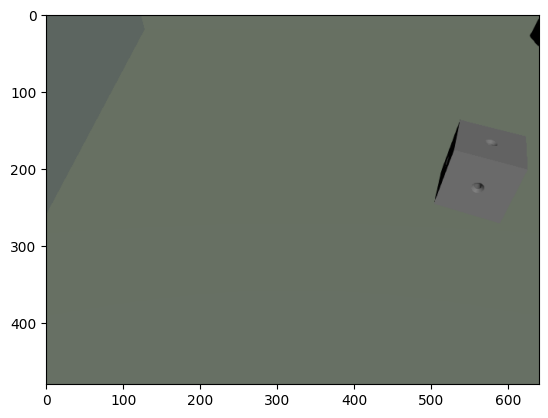

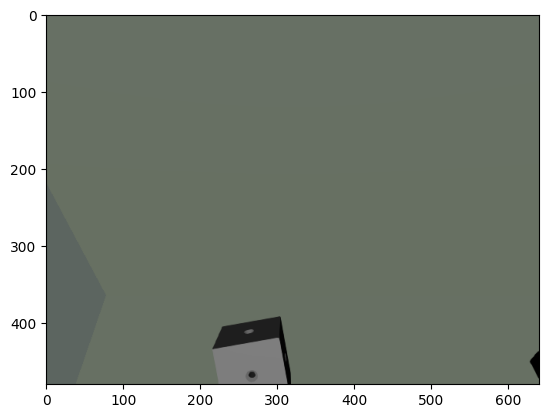

In [ ]:
point_cloud = diagram.GetOutputPort(
            "camera0_point_cloud"
        ).Eval(context)
meshcat.SetObject(f"Camera 0 point cloud", point_cloud)
plt.imshow(diagram.GetOutputPort("camera0_rgb_image").Eval(context).data)
plt.show()
point_cloud = diagram.GetOutputPort(
            "camera1_point_cloud"
        ).Eval(context)
meshcat.SetObject(f"Camera 1 point cloud", point_cloud)
plt.imshow(diagram.GetOutputPort("camera1_rgb_image").Eval(context).data)
plt.show()
# RenderDiagram(diagram)

In [ ]:


simulator.set_target_realtime_rate(1.0)
simulator.AdvanceTo(np.inf)

Press Escape to stop the simulation


KeyboardInterrupt: 